# K_Mean Clustering Lab Task

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_excel('Online Retail.xlsx')

In [4]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


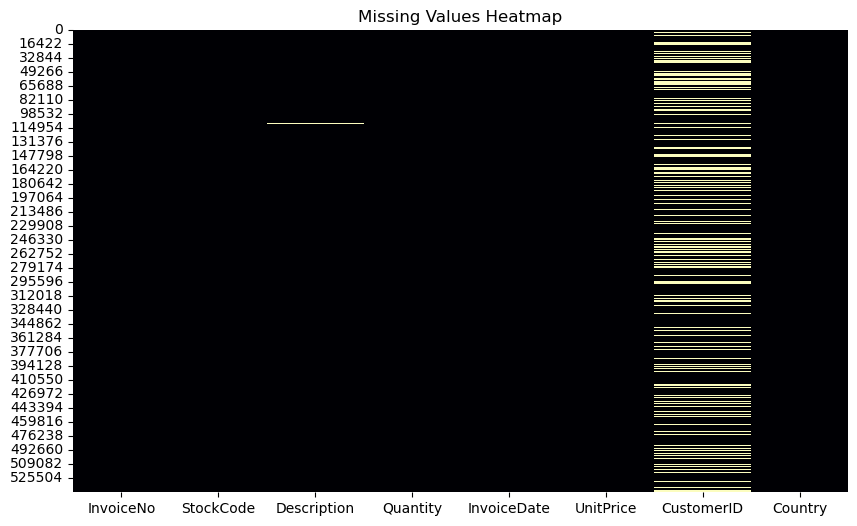

In [7]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cmap='magma', cbar=False)
plt.title('Missing Values Heatmap')
plt.show()

I checked for missing values and removed negative or incorrect values to ensure my analysis is based on valid data.I also converted the CustomerID datatype to ensure it was properly recognized as a categorical or numerical value, allowing for accurate grouping and analysis. Without this, the model might misinterpret customer identifiers or fail to cluster correctly.

In [9]:
# Remove rows with missing CustomerID
df = df.dropna(subset=["CustomerID"])

# Remove rows with negative or zero Quantity and UnitPrice
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

# Convert CustomerID to integer type
df["CustomerID"] = df["CustomerID"].astype(int)

df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,397884.000000,397884,397884.000000,397884.000000
mean,12.988238,2011-07-10 23:41:23.511023360,3.116488,15294.423453
min,1.000000,2010-12-01 08:26:00,0.001000,12346.000000
25%,2.000000,2011-04-07 11:12:00,1.250000,13969.000000
50%,6.000000,2011-07-31 14:39:00,1.950000,15159.000000
75%,12.000000,2011-10-20 14:33:00,3.750000,16795.000000
max,80995.000000,2011-12-09 12:50:00,8142.750000,18287.000000
std,179.331775,NaN,22.097877,1713.141560


I created new features instead of using the existing ones because the raw data didn't fully capture the patterns I needed for clustering. By calculating new values like 'Revenue' (TotalQuantity × UnitPrice) or aggregating transactions per customer, I could better understand customer purchasing behavior. This helped K-Means identify meaningful groups rather than clustering based on incomplete or less useful raw features.

In [11]:
# Create a new Revenue column
df["Revenue"] = df["Quantity"] * df["UnitPrice"]

# Aggregate customer behavior
customer_data = df.groupby("CustomerID").agg(
    TotalSpending=("Revenue", "sum"),
    TotalQuantity=("Quantity", "sum"),
    TotalTransactions=("InvoiceNo", "nunique")
).reset_index()

customer_data.describe()

,CustomerID,TotalSpending,TotalQuantity,TotalTransactions
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,2054.266460,1191.289073,4.272015
std,1721.808492,8989.230441,5046.081546,7.697998
min,12346.000000,3.750000,1.000000,1.000000
25%,13813.250000,307.415000,160.000000,1.000000
50%,15299.500000,674.485000,379.000000,2.000000
75%,16778.750000,1661.740000,992.750000,5.000000
max,18287.000000,280206.020000,196915.000000,209.000000


I used StandardScaler to normalize my data because K-Means works better when all features have the same scale.

In [13]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_data[["TotalSpending", "TotalQuantity", "TotalTransactions"]])

# Convert back to DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=["TotalSpending", "TotalQuantity", "TotalTransactions"])

I used the elbow method to determine the optimal number of clusters by plotting inertia values and identifying the 'bend' point.

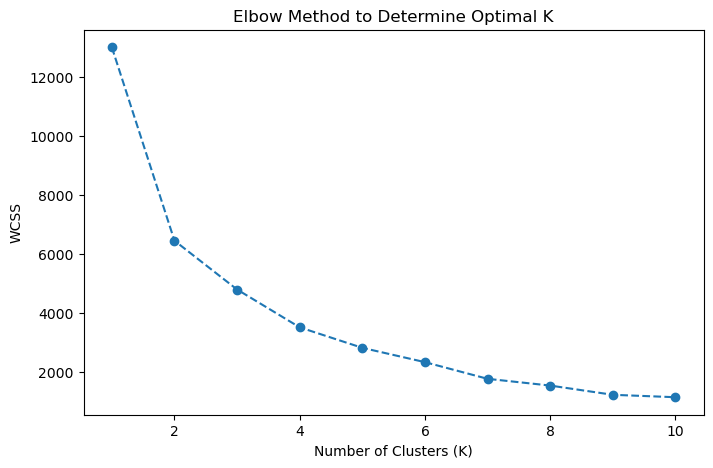

In [15]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)

# Plot Elbow Graph
plt.figure(figsize=(8,5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS")
plt.title("Elbow Method to Determine Optimal K")
plt.show()

I applied K-Means with k=3 because the elbow method showed that it’s the optimal number of clusters, balancing accuracy and simplicity.

In [17]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data["Cluster"] = kmeans.fit_predict(scaled_df)

I created a scatter plot to visualize the three customer groups (0, 1, 2) identified by K-Means clustering. Each color represents a different cluster based on TotalQuantity and TotalTransactions, helping me understand distinct purchasing patterns.

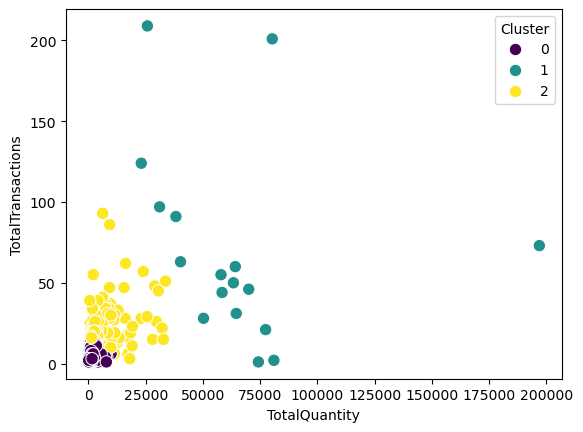

In [19]:
sns.scatterplot(x='TotalQuantity', y='TotalTransactions', data=customer_data, hue='Cluster' , palette="viridis", s=80)
plt.show()

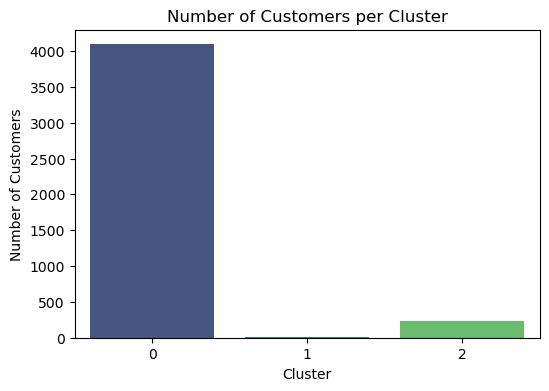

In [20]:
plt.figure(figsize=(6,4))
sns.countplot(x=customer_data["Cluster"], palette="viridis")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.title("Number of Customers per Cluster")
plt.show()

In [21]:
import joblib

joblib.dump(kmeans, "knn_model.pkl")
print("Model saved successfully!")

Model saved successfully!


In [37]:
customer_data.to_csv("Knn_customer_data.csv", index=False)  # Set index=True if you want to keep index
print("CSV file saved successfully!")

CSV file saved successfully!
